In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

Setting Time Range and Ticker List

In [ ]:
### Set time from to a certain number of years
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

In [ ]:
### Create a list of tickers
tickers = ['SPY','BND','GLD','QQQ','VTI']
##ETFs of S&P 500, Bonds, Gold, Nasdaq, vangaurd all world stock

Downloading Adjusted Close Prices

In [ ]:
### Download the daily adjusted close prices for the tickers
##adjusted accounts for dividends and stock splits - better for analysis
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2009-09-29   80.300896  51.767162   97.430000   36.875572   41.058399
2009-09-30   79.990280  51.767162   98.849998   36.901794   40.905735
2009-10-01   78.005501  52.000973   97.889999   35.810017   39.821838
2009-10-02   77.641907  51.844250   98.370003   35.705181   39.585224
2009-10-05   78.800919  51.922596   99.820000   35.993416   40.195843
...                ...        ...         ...         ...         ...
2024-09-18  559.683350  75.309998  235.509995  470.778442  277.350006
2024-09-19  569.234009  75.309998  239.169998  482.681702  282.049988
2024-09-20  568.250000  75.300003  242.210007  481.763000  281.459991
2024-09-23  569.669983  75.250000  242.679993  483.040009  282.160004
2024-09-24  571.299988  75.339996  246.070007  485.369995  282.869995

[3772 rows x 5 columns]


Calculating Daily Log Returns

In [ ]:
### Calculate the daily log returns and drop any NAs
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns  = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2009-09-30 -0.003876  0.000000  0.014469  0.000711 -0.003725
2009-10-01 -0.025126  0.004506 -0.009759 -0.030033 -0.026855
2009-10-02 -0.004672 -0.003018  0.004892 -0.002932 -0.005960
2009-10-05  0.014817  0.001510  0.014633  0.008040  0.015308
2009-10-06  0.014223  0.001132  0.024346  0.017559  0.014703
...              ...       ...       ...       ...       ...
2024-09-18 -0.002970 -0.003049 -0.007740 -0.004339 -0.002521
2024-09-19  0.016920  0.000000  0.015421  0.024970  0.016804
2024-09-20 -0.001730 -0.000133  0.012631 -0.001905 -0.002094
2024-09-23  0.002496 -0.000664  0.001939  0.002647  0.002484
2024-09-24  0.002857  0.001195  0.013872  0.004812  0.002513

[3771 rows x 5 columns]


Functions to Calculate Portfolio Expected Return and Standard Deviation

In [ ]:
### Create a function that will be used to calculate portfolio expected return
#We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

### Create a function that will be used to calculate portfolio standard deviation
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [ ]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)

              SPY           BND       GLD           QQQ           VTI
SPY  1.168662e-04 -1.900035e-08  0.000007  1.294795e-04  1.193090e-04
BND -1.900035e-08  9.228360e-06  0.000009  8.421490e-07  1.666390e-07
GLD  6.650039e-06  8.884498e-06  0.000097  7.779562e-06  7.246745e-06
QQQ  1.294795e-04  8.421490e-07  0.000008  1.664473e-04  1.322525e-04
VTI  1.193090e-04  1.666390e-07  0.000007  1.322525e-04  1.227833e-04


Calculating Portfolio Expected Return and Standard Deviation

In [ ]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

##equally weighted portfolio and calculate the portfolio’s expected return and standard deviation using the functions

 Functions for Monte Carlo Simulation

In [ ]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 20

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

##the first function generates a random Z-score based on a normal distribution, and the second function calculates the gain or loss for a given scenario.
##Scenario Gain-Loss

Monte Carlo Simulation

 run 10,000 Monte Carlo simulations, calculating the scenario gain/loss for each simulation and storing the results in a list.

In [ ]:
### Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

Calculating Value at Risk (VaR)

 specify a confidence interval of 99% and calculate Value at Risk (VaR) using the results of our simulations.

In [ ]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

69348.37706548738


Results

vertical dashed line indicates the VaR at our chosen confidence level.

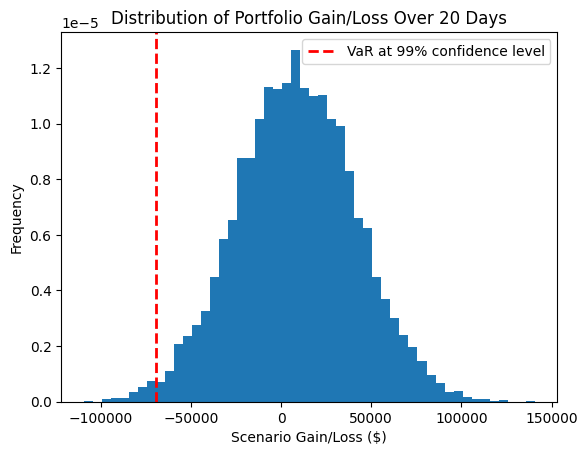

In [ ]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()

[*********************100%***********************]  3 of 3 completed


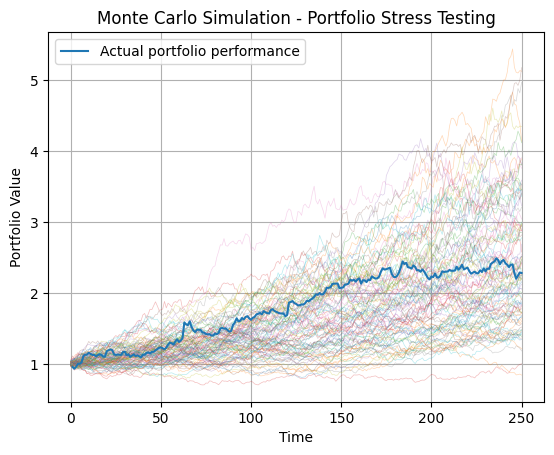

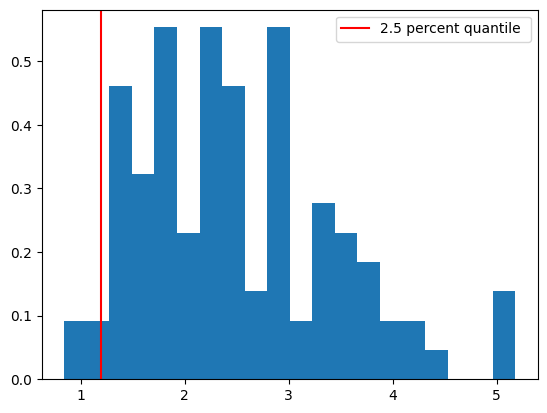

In 97.5 percent of the cases, the portfolio does not lose more than -0.1949 percent of its value


In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime

class stress_testing:
    '''
    tikers: a list with ticker names
    positions: a numpy array with weights in each stock considered. The weights has to sum to 1.
    n_sims: int, that determines the amount of simulations.
    start_data and end_date: datetime objects

    The object conntains two methods.
    1: montecarlo_sim.
    Simulates a correlated returns time series of the data.
    2: asses_worst_cases.
    Estimates the lower quantile of the simulated paths, and estimates the worst cases of the portfolio.

    '''

    def __init__(self, tickers, positions, n_sims = 1000,
                 start_date = (datetime.datetime.now() - datetime.timedelta(days=3*365)).date(),
                 end_date = datetime.datetime.now().date()):

        if len(tickers) != len(positions):
            raise Exception('The dimension of the position is not same as the chosen stocks')

        self.tickers = tickers
        self.positions = positions
        if sum(self.positions) != 1:
            raise Exception('The weights does not sum up to 1')

        self.start_date = start_date
        self.end_date = end_date
        self.data = self.get_data()
        self.n_sims = n_sims
        self.returns = self.data.pct_change()
        self.portfolio_values = np.zeros((len(self.returns), self.n_sims))
        self.mean_returns = self.returns.mean()
        self.cov_matrix = self.returns.cov()

    def get_data(self):
        m = ' '.join(self.tickers)
        data = yf.download(
            m,
            start = self.start_date,
            end = self.end_date
        )['Adj Close']
        return data

    def monte_carlo_sim(self):
        for i in range(self.n_sims):
            scenario_returns = np.random.multivariate_normal(self.mean_returns, self.cov_matrix, len(self.returns))
            scenario_returns = pd.DataFrame(scenario_returns, columns=self.returns.columns)
            # Calculate the value for each scenario
            cop = self.portfolio_values

            scenario_portfolio = (1+scenario_returns).cumprod()
            self.portfolio_values[:, i] = np.dot(
                self.positions, scenario_portfolio.T
            )

        for i in range(self.n_sims):
            plt.plot(self.portfolio_values[:, i], linewidth=0.5, alpha=0.3)

        plt.title('Monte Carlo Simulation - Portfolio Stress Testing')
        plt.xlabel('Time')
        plt.ylabel('Portfolio Value')
        plt.grid(True)
        # plt.plot(np.dot(self.positions, (1+self.returns.cumprod()).T))
        c_r = (1+self.returns).cumprod()
        pf_val = np.dot(self.positions, c_r.T)
        plt.plot(pf_val, label = 'Actual portfolio performance')
        plt.legend(loc = 'upper left')
        plt.show()

    def asses_worst_cases(self):

        q = np.quantile(self.portfolio_values[-1: ][0], 0.025)
        plt.hist(np.array(self.portfolio_values[-1: ][0]), bins = 20, density=True)
        plt.axvline(q, color = 'red', label = '2.5 percent quantile ')
        plt.legend()
        plt.show()

        print(f'In 97.5 percent of the cases, the portfolio does not lose more than {round(1-q, 4)} percent of its value'
              )


### Example of usage ###

# Define the input for the object.
start_date = datetime.date(2022, 11, 1)
end_date = datetime.date(2023, 11, 1)
ticker_symbols = ['META', 'MSFT', 'GOOGL']
weights = np.array([0.4, 0.5, 0.1])

# Initiate the object.

obj1 = stress_testing(['META', 'MSFT', 'GOOGL'], weights, n_sims=100, start_date=start_date, end_date=end_date)

# Apply the monte carlo simulation scheme.

obj1.monte_carlo_sim()
obj1.asses_worst_cases()